# Data Analytics for Health - Task 2.4: Final Clustering Evaluation and Comparison

## Overview
This notebook performs final evaluation and comparison of all clustering methods:
- K-means clustering
- Density-based clustering (DBSCAN)
- Hierarchical clustering

## Objectives
- Compare clustering results from all three methods
- Evaluate and compare performance metrics
- Visualize differences between clustering approaches
- Select the best clustering approach for the dataset
- Discuss advantages and disadvantages of each method

---


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / 'Data').resolve()
plots_dir = (notebook_dir / '..' / 'plots').resolve()
plots_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Plots directory: {plots_dir}")


Libraries imported successfully
Data path: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\Data
Plots directory: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\data_analytics_4_health_unipi\plots


## 1. Load Data and Clustering Results


In [18]:
# Load prepared patient profile
df = pd.read_csv(data_path / 'patient_profile_broad_clean_clustering.csv')  

print(f"Loaded patient profile: {df.shape[0]:,} subjects × {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")

# Get numeric features (excluding subject_id and categorical variables)
numeric_features = [col for col in df.columns if col != 'subject_id' and col != 'hadm_id' and df[col].dtype in [np.float64, np.int64]]
print(f"\nNumeric features for clustering: {len(numeric_features)}")
print(f"Features: {numeric_features}")

# Prepare data
X = df[numeric_features].copy()
X = X.fillna(X.mean())
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Load clustering results
try:
    df_kmeans = pd.read_csv(data_path / '2.1_kmeans_clustered_data.csv')
    labels_kmeans = df_kmeans['cluster'].values
    print(f"\n✓ Loaded K-means results: {len(np.unique(labels_kmeans))} clusters")
except FileNotFoundError:
    print("\n✗ K-means results not found. Run 2.1_kmeans_clustering.ipynb first.")
    labels_kmeans = None

try:
    df_dbscan = pd.read_csv(data_path / '2.2_dbscan_clustered_data.csv')
    labels_dbscan = df_dbscan['cluster'].values
    n_clusters_dbscan = len(np.unique(labels_dbscan[labels_dbscan != -1]))
    n_noise_dbscan = np.sum(labels_dbscan == -1)
    print(f"✓ Loaded DBSCAN results: {n_clusters_dbscan} clusters, {n_noise_dbscan} noise points")
except FileNotFoundError:
    print("✗ DBSCAN results not found. Run 2.2_density_based_clustering.ipynb first.")
    labels_dbscan = None

try:
    df_hierarchical = pd.read_csv(data_path / '2.3_hierarchical_clustered_data.csv')
    labels_hierarchical = df_hierarchical['cluster'].values
    print(f"✓ Loaded Hierarchical results: {len(np.unique(labels_hierarchical))} clusters")
except FileNotFoundError:
    print("✗ Hierarchical results not found. Run 2.3_hierarchical_clustering.ipynb first.")
    labels_hierarchical = None


Loaded patient profile: 5,166 subjects × 25 features

Columns: ['subject_id', 'hadm_id', 'is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'oxygenation_dysfunction_index', 'inflammation_liver_stress_index', 'hematologic_stability_score', 'renal_failure_index']

Numeric features for clustering: 23
Features: ['is_dead', 'abnormal_ratio', 'qc_fail_ratio', 'fluid_diversity', 'max_blood_sodium', 'num_intermediate', 'susceptible_ratio', 'micro_qc_fail', 'micro_qc_warn', 'age_missing', 'max_urine_creatinine_missing', 'max_gas_pO2_missing', 'procedure_span_days_missing', 'gender_F', 'clinical_activity', 'micro_resistance_score', 'history_depth', 'procedure_density',

## 2. Comprehensive Evaluation Metrics Comparison


In [19]:
# Compute evaluation metrics for each method
evaluation_results = []

methods = {
    'K-means': labels_kmeans,
    'DBSCAN': labels_dbscan,
    'Hierarchical': labels_hierarchical
}

for method_name, labels in methods.items():
    if labels is not None:
        # Basic statistics
        unique_labels = np.unique(labels)
        n_clusters = len(unique_labels[unique_labels != -1]) if -1 in unique_labels else len(unique_labels)
        n_noise = np.sum(labels == -1) if -1 in labels else 0
        
        # Compute metrics (excluding noise for DBSCAN)
        if n_clusters >= 2:
            if -1 in labels:
                # DBSCAN: exclude noise points
                non_noise_mask = labels != -1
                if np.sum(non_noise_mask) > 1:
                    silhouette = silhouette_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                    davies_bouldin = davies_bouldin_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                    calinski_harabasz = calinski_harabasz_score(X_scaled[non_noise_mask], labels[non_noise_mask])
                else:
                    silhouette = -1
                    davies_bouldin = np.inf
                    calinski_harabasz = 0
            else:
                # K-means and Hierarchical: use all points
                silhouette = silhouette_score(X_scaled, labels)
                davies_bouldin = davies_bouldin_score(X_scaled, labels)
                calinski_harabasz = calinski_harabasz_score(X_scaled, labels)
        else:
            silhouette = -1
            davies_bouldin = np.inf
            calinski_harabasz = 0
        
        evaluation_results.append({
            'Method': method_name,
            'N_Clusters': n_clusters,
            'N_Noise': n_noise,
            'Noise_Ratio': n_noise / len(labels) if len(labels) > 0 else 0,
            'Silhouette_Score': silhouette,
            'Davies_Bouldin': davies_bouldin,
            'Calinski_Harabasz': calinski_harabasz
        })

evaluation_df = pd.DataFrame(evaluation_results)
print("="*80)
print("COMPREHENSIVE EVALUATION METRICS")
print("="*80)
print(evaluation_df.to_string(index=False))


COMPREHENSIVE EVALUATION METRICS
      Method  N_Clusters  N_Noise  Noise_Ratio  Silhouette_Score  Davies_Bouldin  Calinski_Harabasz
     K-means           2        0     0.000000          0.940962        0.049000       98572.631338
      DBSCAN           2       16     0.003097          0.942696        0.047962      118697.191031
Hierarchical           4        0     0.000000          0.611249        0.704325       47921.902602


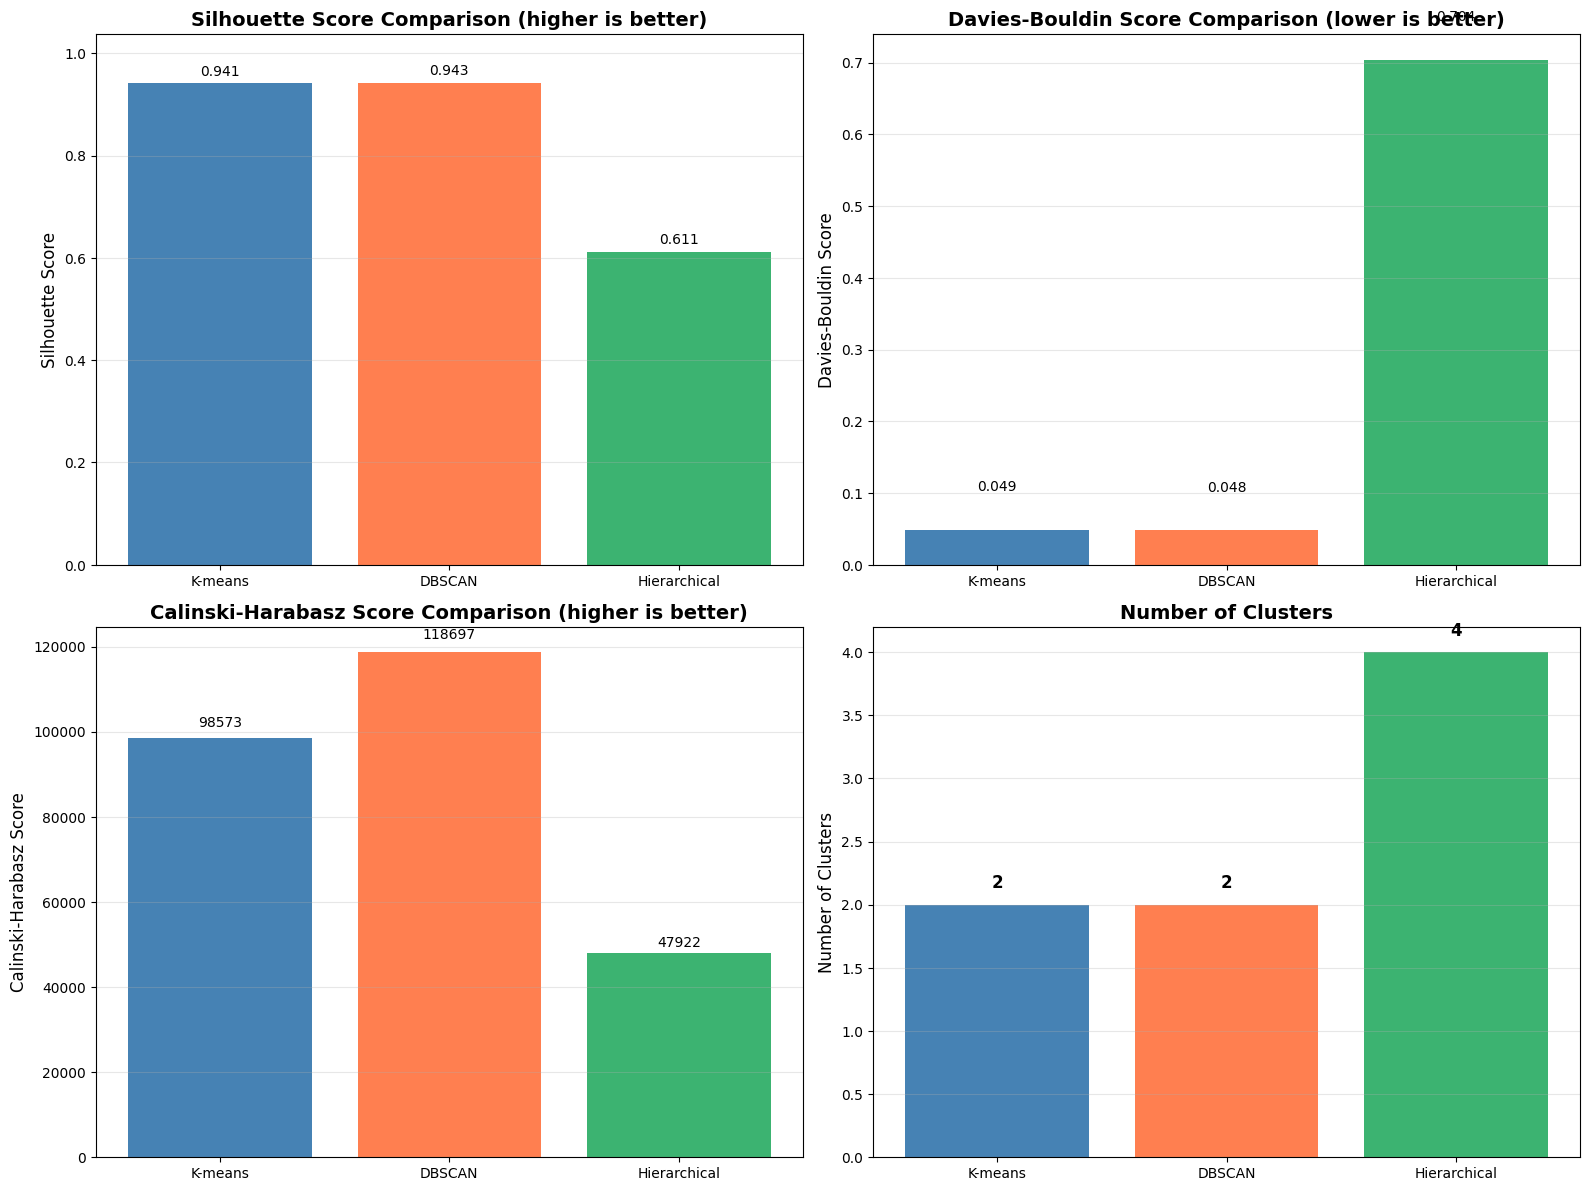

In [20]:
# Visualize comparison of metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Silhouette Score
ax = axes[0, 0]
valid_data = evaluation_df[evaluation_df['Silhouette_Score'] >= 0]
if len(valid_data) > 0:
    bars = ax.bar(valid_data['Method'], valid_data['Silhouette_Score'], 
                  color=['steelblue', 'coral', 'mediumseagreen'][:len(valid_data)])
    ax.set_ylabel('Silhouette Score', fontsize=12)
    ax.set_title('Silhouette Score Comparison (higher is better)', fontsize=14, fontweight='bold')
    ax.set_ylim([0, max(1, valid_data['Silhouette_Score'].max() * 1.1)])
    ax.grid(True, alpha=0.3, axis='y')
    for i, (idx, row) in enumerate(valid_data.iterrows()):
        ax.text(i, row['Silhouette_Score'] + 0.01, f"{row['Silhouette_Score']:.3f}", 
               ha='center', va='bottom', fontsize=10)

# Davies-Bouldin Score
ax = axes[0, 1]
valid_data = evaluation_df[evaluation_df['Davies_Bouldin'] < np.inf]
if len(valid_data) > 0:
    bars = ax.bar(valid_data['Method'], valid_data['Davies_Bouldin'],
                  color=['steelblue', 'coral', 'mediumseagreen'][:len(valid_data)])
    ax.set_ylabel('Davies-Bouldin Score', fontsize=12)
    ax.set_title('Davies-Bouldin Score Comparison (lower is better)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for i, (idx, row) in enumerate(valid_data.iterrows()):
        ax.text(i, row['Davies_Bouldin'] + 0.05, f"{row['Davies_Bouldin']:.3f}", 
               ha='center', va='bottom', fontsize=10)

# Calinski-Harabasz Score
ax = axes[1, 0]
valid_data = evaluation_df[evaluation_df['Calinski_Harabasz'] > 0]
if len(valid_data) > 0:
    bars = ax.bar(valid_data['Method'], valid_data['Calinski_Harabasz'],
                  color=['steelblue', 'coral', 'mediumseagreen'][:len(valid_data)])
    ax.set_ylabel('Calinski-Harabasz Score', fontsize=12)
    ax.set_title('Calinski-Harabasz Score Comparison (higher is better)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for i, (idx, row) in enumerate(valid_data.iterrows()):
        ax.text(i, row['Calinski_Harabasz'] + row['Calinski_Harabasz']*0.02, 
               f"{row['Calinski_Harabasz']:.0f}", ha='center', va='bottom', fontsize=10)

# Number of Clusters
ax = axes[1, 1]
bars = ax.bar(evaluation_df['Method'], evaluation_df['N_Clusters'],
             color=['steelblue', 'coral', 'mediumseagreen'][:len(evaluation_df)])
ax.set_ylabel('Number of Clusters', fontsize=12)
ax.set_title('Number of Clusters', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (idx, row) in enumerate(evaluation_df.iterrows()):
    ax.text(i, row['N_Clusters'] + 0.1, f"{int(row['N_Clusters'])}", 
           ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(plots_dir / '2.4_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Cluster Agreement Analysis


In [21]:
# Compute Adjusted Rand Index (ARI) between different methods
if labels_kmeans is not None and labels_hierarchical is not None:
    ari_kmeans_hierarchical = adjusted_rand_score(labels_kmeans, labels_hierarchical)
    print(f"Adjusted Rand Index (K-means vs Hierarchical): {ari_kmeans_hierarchical:.4f}")

if labels_kmeans is not None and labels_dbscan is not None:
    # For DBSCAN, compare only non-noise points
    non_noise_mask = labels_dbscan != -1
    if np.sum(non_noise_mask) > 0:
        ari_kmeans_dbscan = adjusted_rand_score(
            labels_kmeans[non_noise_mask], 
            labels_dbscan[non_noise_mask]
        )
        print(f"Adjusted Rand Index (K-means vs DBSCAN, non-noise only): {ari_kmeans_dbscan:.4f}")

if labels_hierarchical is not None and labels_dbscan is not None:
    non_noise_mask = labels_dbscan != -1
    if np.sum(non_noise_mask) > 0:
        ari_hierarchical_dbscan = adjusted_rand_score(
            labels_hierarchical[non_noise_mask],
            labels_dbscan[non_noise_mask]
        )
        print(f"Adjusted Rand Index (Hierarchical vs DBSCAN, non-noise only): {ari_hierarchical_dbscan:.4f}")

# Create agreement matrix
agreement_data = []
if labels_kmeans is not None and labels_hierarchical is not None:
    agreement_data.append(['K-means', 'Hierarchical', adjusted_rand_score(labels_kmeans, labels_hierarchical)])
if labels_kmeans is not None and labels_dbscan is not None:
    non_noise_mask = labels_dbscan != -1
    if np.sum(non_noise_mask) > 0:
        agreement_data.append(['K-means', 'DBSCAN', adjusted_rand_score(labels_kmeans[non_noise_mask], labels_dbscan[non_noise_mask])])
if labels_hierarchical is not None and labels_dbscan is not None:
    non_noise_mask = labels_dbscan != -1
    if np.sum(non_noise_mask) > 0:
        agreement_data.append(['Hierarchical', 'DBSCAN', adjusted_rand_score(labels_hierarchical[non_noise_mask], labels_dbscan[non_noise_mask])])

if agreement_data:
    agreement_df = pd.DataFrame(agreement_data, columns=['Method 1', 'Method 2', 'ARI'])
    print("\n" + "="*80)
    print("CLUSTER AGREEMENT (Adjusted Rand Index)")
    print("="*80)
    print(agreement_df.to_string(index=False))
    print("\nNote: ARI ranges from -1 to 1, where 1 indicates perfect agreement")


Adjusted Rand Index (K-means vs Hierarchical): 0.6027
Adjusted Rand Index (K-means vs DBSCAN, non-noise only): 1.0000
Adjusted Rand Index (Hierarchical vs DBSCAN, non-noise only): 0.6129

CLUSTER AGREEMENT (Adjusted Rand Index)
    Method 1     Method 2      ARI
     K-means Hierarchical 0.602715
     K-means       DBSCAN 1.000000
Hierarchical       DBSCAN 0.612878

Note: ARI ranges from -1 to 1, where 1 indicates perfect agreement


## 4. Visual Comparison of Clustering Results


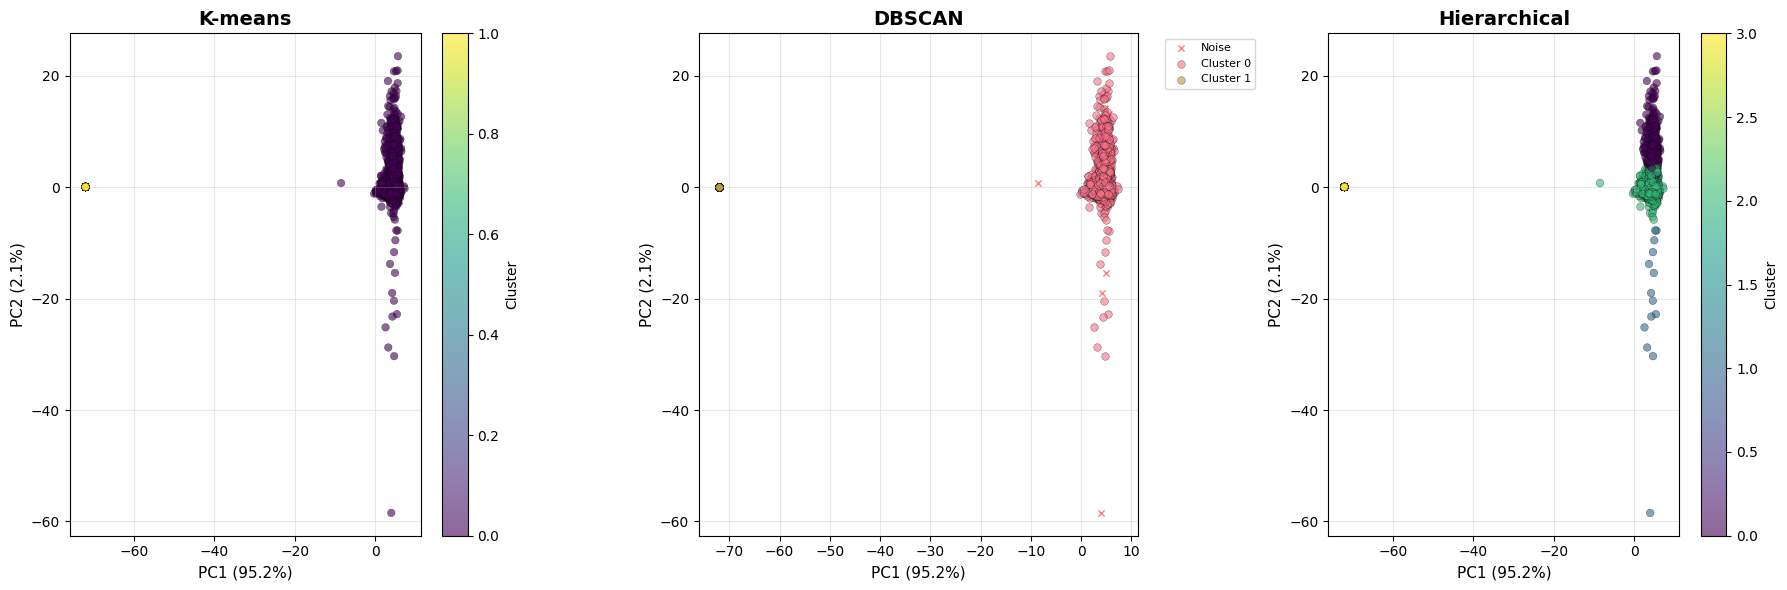

PCA explained variance: 97.35%


In [22]:
# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create side-by-side comparison
n_methods = sum([1 for labels in methods.values() if labels is not None])
fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 6))

plot_idx = 0
for method_name, labels in methods.items():
    if labels is not None:
        ax = axes[plot_idx] if n_methods > 1 else axes
        
        # Plot clusters
        if -1 in labels:
            # DBSCAN: handle noise points
            for cluster_id in sorted(np.unique(labels)):
                mask = labels == cluster_id
                if cluster_id == -1:
                    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                             c='red', marker='x', s=20, alpha=0.5, label='Noise', linewidths=1)
                else:
                    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                             label=f'Cluster {cluster_id}', alpha=0.6, s=30, edgecolors='k', linewidth=0.3)
        else:
            # K-means and Hierarchical
            scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                               cmap='viridis', alpha=0.6, s=30, edgecolors='k', linewidth=0.3)
            plt.colorbar(scatter, ax=ax, label='Cluster')
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
        ax.set_title(f'{method_name}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        if -1 in labels:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        
        plot_idx += 1

plt.tight_layout()
plt.savefig(plots_dir / '2.4_clustering_visual_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")


## 5. Method Comparison: Advantages and Disadvantages


In [23]:
comparison_table = pd.DataFrame({
    'Method': ['K-means', 'DBSCAN', 'Hierarchical'],
    'Advantages': [
        'Fast and scalable; Works well with spherical clusters; Simple to implement',
        'Finds clusters of arbitrary shape; Identifies noise/outliers; No need to specify k',
        'Provides hierarchical structure; No need to specify k; Interpretable dendrograms'
    ],
    'Disadvantages': [
        'Assumes spherical clusters; Requires k a priori; Sensitive to initialization',
        'Sensitive to parameters (eps, min_samples); Struggles with varying densities',
        'Computationally expensive; Sensitive to noise; Different linkage methods give different results'
    ],
    'Best For': [
        'Well-separated, spherical clusters; Large datasets',
        'Clusters of arbitrary shape; Outlier detection; Unknown number of clusters',
        'Small to medium datasets; Need for hierarchical structure; Interpretability'
    ]
})

print("="*80)
print("METHOD COMPARISON: ADVANTAGES AND DISADVANTAGES")
print("="*80)
for idx, row in comparison_table.iterrows():
    print(f"\n{row['Method']}:")
    print(f"  Advantages: {row['Advantages']}")
    print(f"  Disadvantages: {row['Disadvantages']}")
    print(f"  Best For: {row['Best For']}")


METHOD COMPARISON: ADVANTAGES AND DISADVANTAGES

K-means:
  Advantages: Fast and scalable; Works well with spherical clusters; Simple to implement
  Disadvantages: Assumes spherical clusters; Requires k a priori; Sensitive to initialization
  Best For: Well-separated, spherical clusters; Large datasets

DBSCAN:
  Advantages: Finds clusters of arbitrary shape; Identifies noise/outliers; No need to specify k
  Disadvantages: Sensitive to parameters (eps, min_samples); Struggles with varying densities
  Best For: Clusters of arbitrary shape; Outlier detection; Unknown number of clusters

Hierarchical:
  Advantages: Provides hierarchical structure; No need to specify k; Interpretable dendrograms
  Disadvantages: Computationally expensive; Sensitive to noise; Different linkage methods give different results
  Best For: Small to medium datasets; Need for hierarchical structure; Interpretability


## 6. Final Recommendations and Conclusions


In [24]:
# Determine best method based on metrics
if len(evaluation_df) > 0:
    # Normalize scores for comparison (higher is better for all after normalization)
    eval_normalized = evaluation_df.copy()
    
    # Silhouette: already in [-1, 1], higher is better
    eval_normalized['Silhouette_Norm'] = eval_normalized['Silhouette_Score']
    
    # Davies-Bouldin: lower is better, so invert
    max_db = eval_normalized[eval_normalized['Davies_Bouldin'] < np.inf]['Davies_Bouldin'].max()
    eval_normalized['DB_Norm'] = 1 - (eval_normalized['Davies_Bouldin'] / max_db)
    eval_normalized.loc[eval_normalized['Davies_Bouldin'] == np.inf, 'DB_Norm'] = 0
    
    # Calinski-Harabasz: higher is better, normalize
    max_ch = eval_normalized['Calinski_Harabasz'].max()
    eval_normalized['CH_Norm'] = eval_normalized['Calinski_Harabasz'] / max_ch
    
    # Combined score (weighted average)
    eval_normalized['Combined_Score'] = (
        0.4 * eval_normalized['Silhouette_Norm'] +
        0.3 * eval_normalized['DB_Norm'] +
        0.3 * eval_normalized['CH_Norm']
    )
    
    best_method = eval_normalized.loc[eval_normalized['Combined_Score'].idxmax(), 'Method']
    
    print("="*80)
    print("FINAL RECOMMENDATION")
    print("="*80)
    print(f"\nBased on comprehensive evaluation metrics, the best clustering method is:")
    print(f"  → {best_method}")
    print(f"\nCombined Score: {eval_normalized.loc[eval_normalized['Method'] == best_method, 'Combined_Score'].values[0]:.4f}")
    print(f"\nDetailed metrics for {best_method}:")
    best_row = evaluation_df[evaluation_df['Method'] == best_method].iloc[0]
    print(f"  - Number of clusters: {int(best_row['N_Clusters'])}")
    if best_row['N_Noise'] > 0:
        print(f"  - Noise points: {int(best_row['N_Noise'])} ({best_row['Noise_Ratio']:.1%})")
    print(f"  - Silhouette Score: {best_row['Silhouette_Score']:.4f}")
    print(f"  - Davies-Bouldin Score: {best_row['Davies_Bouldin']:.4f}")
    print(f"  - Calinski-Harabasz Score: {best_row['Calinski_Harabasz']:.4f}")
    
    print("\n" + "="*80)
    print("ALL METHODS RANKED BY COMBINED SCORE")
    print("="*80)
    ranked = eval_normalized.sort_values('Combined_Score', ascending=False)[['Method', 'Combined_Score', 'Silhouette_Score', 'Davies_Bouldin', 'Calinski_Harabasz']]
    print(ranked.to_string(index=False))


FINAL RECOMMENDATION

Based on comprehensive evaluation metrics, the best clustering method is:
  → DBSCAN

Combined Score: 0.9566

Detailed metrics for DBSCAN:
  - Number of clusters: 2
  - Noise points: 16 (0.3%)
  - Silhouette Score: 0.9427
  - Davies-Bouldin Score: 0.0480
  - Calinski-Harabasz Score: 118697.1910

ALL METHODS RANKED BY COMBINED SCORE
      Method  Combined_Score  Silhouette_Score  Davies_Bouldin  Calinski_Harabasz
      DBSCAN        0.956649          0.942696        0.047962      118697.191031
     K-means        0.904650          0.940962        0.049000       98572.631338
Hierarchical        0.365619          0.611249        0.704325       47921.902602
